# Cloud-optimized geo data formats and the Python ecosystem

**Emilio Mayorga**  
Senior Oceanographer  
Applied Physics Laboratory  
University of Washington, Seattle  
emiliom@uw.edu  

---------------------------

CUGOS Spring Fling, 2023-04-21 (*updated 2023-05-24*)

## Creating a Python environment to run the code in this notebook

INSTALL THESE PACKAGES, VIA CONDA OR OTHERWISE

``
mamba create -c conda-forge -n cloud_native_formats jupyter aiohttp aiobotocore s3fs fsspec geopandas rasterio xarray dask pystac matplotlib zarr pyarrow fastparquet python-snappy
```

## Cloudy forecast

Nasty thunderstorms or pleasant clouds?

- Lots of large geospatial data out there, online, from many different providers. Much of it on "the cloud"
- But access alone doesn't equal convenient, scalable access to data subsets
- Placing any old file on cloud storage doesn't guarantee scalable access

### This presentation

- Focus on cloud-native data formats that support analytical use cases, not just visualization
- Won't focus on data access mechanisms dependent on server applications
- Primary geospatial types: **simple rasters**, **vector**, and **multi-dimensional grids**. Other types like point clouds are out of my wheelhouse.
- Bird's eyeview, for the most part! I don't actively use some of this stuff
- Concepts and programmatic access via Python
- Make things more concrete by presenting Python libraries that leverage these formats

## Cloud storage, object storage

"Cloud storage" can mean different things. In most cases: ["object storage"](https://en.wikipedia.org/wiki/Object_storage), such as AWS "S3 buckets". All major cloud vendors provide object storage.


### Object storage

- "Flat" storage, unlike typical file systems. Key-value system: key -> unique identifier, value -> the data object. Can mimic a hierarchical directory structure.
- Access via **http** protocol and access patterns
- "Infinitely" scalable: add more objects without impacting performance (unlike file systems).
- Encourages parallel processing to leverage this system characteristic.
- Break up large files using a chunking (data partitioning) scheme that aligns with expected, most common access / query patterns.
- http byte range access to chunks *within* files **or** access to chunks as clearly organized and indexed files.

### Object storage, continued

- Flexible object metadata
- Promotes "file" (or object) based access, rather than relying on server software. APIs may facilitate access, but access mechanism can operate on file objects that are cloud optimized. Simpler to deploy, simpler to build clients to.
- Can provide fast cloud-to-cloud access, especially when compute is from the same cloud provider and in the same cloud "region"
- Costs: Cloud access considerations
    - "Anonymous" (free, open) vs credentialled (free but controlled) vs  "requester pays"
    - Access from outside the cloud vs within the same cloud provider but different region vs same region
    - *Ingress* vs *egress* costs

## Accessing files (data stores) in object storage

**`fsspec`: a unified Pythonic interface to local, remote, embedded file systems and bytes storage**

- Access to files/objects on local file system, http, zip, S3 buckets, Azure blob storage, etc
- Provides uri-based access patterns: "s3://", "gcs://", "http://", "zip://", etc
- Wraps libraries from each cloud object storage provider in a common interface
- Incorportes authentication mechanisms
- Provides common interface, returns Python "file-like objects"
- But watch out for library dependency conflicts! Things are still moving rapidly
- https://filesystem-spec.readthedocs.io

In [1]:
from pathlib import Path
from aiobotocore.session import get_session
import fsspec

# -----------------------
# Credentialled access. 'ncei_wcsda' is a profile in my ~/.aws/credentials file
aws_profile_name = 'ncei_wcsda'

aws_session = get_session()
aws_session.set_config_variable('profile', aws_profile_name)
fs = fsspec.filesystem('s3', session=aws_session)

# Anonymous, open access
fs = fsspec.filesystem('s3', anon=True)
# -----------------------

bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

fs.ls(bucket)

['ncei-wcsd-archive/data', 'ncei-wcsd-archive/index.html']

In [3]:
ek60filedls = fs.ls(Path(bucket) / rawdirpath, detail=True)
len(ek60filedls)

13029

In [4]:
ek60filedls[:2]

[{'Key': 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/README_SH1707_EK60.md',
  'LastModified': datetime.datetime(2021, 3, 9, 1, 16, 24, tzinfo=tzutc()),
  'ETag': '"fff479454d807c7850e787078807ad48"',
  'Size': 1525,
  'StorageClass': 'STANDARD',
  'type': 'file',
  'size': 1525,
  'name': 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/README_SH1707_EK60.md'},
 {'Key': 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170615-T190214.bot',
  'LastModified': datetime.datetime(2020, 8, 9, 6, 34, 42, tzinfo=tzutc()),
  'ETag': '"c5444c4d232f77ae6d38e60c7745a954"',
  'Size': 2408,
  'StorageClass': 'STANDARD',
  'type': 'file',
  'size': 2408,
  'name': 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170615-T190214.bot'}]

## Raster


**Cloud-Optimized GeoTIFF (COG)**: https://www.cogeo.org. The first unmitigated success for a cloud-optimized geospatial data format.

- From https://cogeo.org: "COG relies on two complementary pieces of technology. The first is the ability of a GeoTIFF to not only store the raw pixels of the image, but to also organize those pixels in particular ways. The second is HTTP GET range requests, that let clients ask for just the portions of a file that they need. Together  these enable fully online processing of data by COG-aware clients, as they can stream the right parts of the GeoTIFF as they need it, instead  of having to download the whole file." 
- Also fundamental: COG embeds in one file low-resolution overviews, tiles, and metadata accessible separately from the data.

## Raster, continued

- COGs leverage existing software that reads GeoTIFF. The software may tap into streaming capabilities, but can easily download the whole dataset and read it.
- **Python** software with COG suppport: `rasterio` (https://rasterio.readthedocs.io), `rioxarray` (https://corteva.github.io/rioxarray/), etc
- Serves both visualization and analysis use cases. RGB's for dynamic maps, though RGB's can also be used analytically, and the same format and tools are used for data access for analysis


**Great, live demo:** https://geotiffjs.github.io/cog-explorer/

### Access COGs from `rasterio` via `fsspec`

Minimal examples of opening Cloud-Optimized GeoTIFFs (COGs) with `rasterio`, where access is facilitated by `fsspec`. After opening, can define a geographical subset that will access only the overlapping COG tiles.

In [5]:
# ----- From http

import fsspec
import rasterio
import rasterio.plot as rioplot

uri = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/DV/2020/4/S2B_13SDV_20200428_0_L2A/TCI.tif'

with fsspec.open(uri) as fobj: 
    with rasterio.open(fobj) as riosrc:
        print(riosrc.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4000020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 344, 'height': 344, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(319.1860465116279, 0.0, 699960.0,
       0.0, -319.1860465116279, 4400040.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


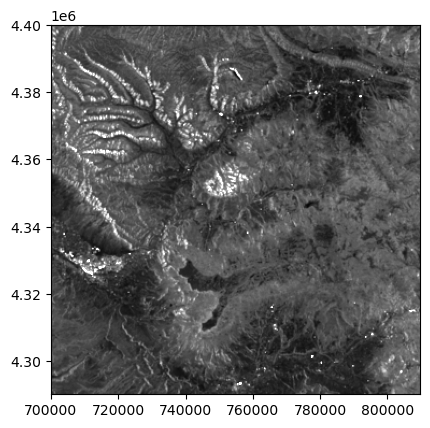

In [6]:
# ----- From an **S3 bucket** uri using an fsspec filesystem object

fs = fsspec.filesystem('s3', anon=True)
s3uri = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/12/S/YJ/2016/S1B_20161121_12SYJ_ASC/Gamma0_VV.tif'

# Open and plot one of the overviews, not the full-resolution data
fobj = fs.open(s3uri)
riosrc = rasterio.open(fobj, overview_level=3)
print(riosrc.profile)
rioplot.show(riosrc, cmap='gray', clim=(0, 0.4));

In [7]:
# Now open (but don't plot!) the full-resolution tiled dataset
with fs.open(s3uri) as fobj: 
    with rasterio.open(fobj) as riosrc:
        print(riosrc.profile)

# (Note to self: https://github.com/rasterio/rasterio/issues/2360)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 5490, 'height': 5490, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(20.0, 0.0, 699960.0,
       0.0, -20.0, 4400040.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


### Side topic: Access STAC Catalog that may contain collections of COGs

- STAC (SpatioTemporal Asset Catalog), https://stacspec.org
- Available as JSON files
- pystac, https://pystac.readthedocs.io
- STAC catalogs can provide consistent access to multiple remote sensing granules

```python
from pystac import Catalog

stac_catalog = 'https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/test/catalog.json'

test_cat = Catalog.from_file(stac_catalog)
```

## Vector

- Points, lines and polygons
- From [Chris Holmes, 2022](https://cholmes.medium.com/an-overview-of-cloud-native-vector-c223845638e0):
    - Vector is a lot more challenging to "cloud-optimize", compared to COGs
    - "For visualization it is really important to  ‘prune’ most of the non-spatial attributes unless they are essential to  rendering, or else the size of each tile will become quite large and thus slow to display. But for analysis it is important to be able to access all the attributes."
- Formats
    - <u>**GeoParquet**</u>: (https://geoparquet.org) A geospatial extension of the widely used, cloud-optimized "columnar" Apache `Parquet` format for tabular data.
    - **FlatGeobuf**: Efficient geometry encoding; fantastic streamable spatial index implementation. A *domain* format developed by the geospatial community.
    - **GeoJSON**: Web and Python-friendly but not realistic for medium-large data

### GeoParquet

- Still a new format with emerging take up
- BUT, `Parquet` has huge takeup in tabular data applications on the cloud and a large ecosystem of tools that support it. Like COG, GeoParquet benefits from existing software ecosystem
- Columnar format, optimized for reading but writing is well supported. Widely used in data science applications.
- Chunked (partitioned) data, with chunks organized as files (and within files?), and external metadata files
- **Python** support: `GeoPandas` (https://geopandas.org), maybe others?
- QGIS supports it (though not for saving to GeoParquet, yet)
- Great reads:
    - https://getindata.com/blog/introducing-geoparquet-data-format/
    - https://kylebarron.dev/blog/geoparquet-on-the-web

**Great, live demo** (but with `FlatGeoBuf`, **not** `GeoParquet`!): https://flatgeobuf.org/examples/leaflet/large.html

### Access GeoParquet from `GeoPandas` via `fsspec`

- `(Geo)Pandas` implements `fsspec` internally, making for easier access patterns
- https://geoparquet.org
- https://geopandas.org/en/stable/docs/reference/api/geopandas.read_parquet.html

In [8]:
# From an S3 uri using an fsspec filesystem object

from aiobotocore.session import get_session
import fsspec
import geopandas as gpd
import pandas as pd

# I'm cheating: This file is not actually a GeoParquet,
# though it does have lat-lon coordinates!
s3uri = 's3://trocas-data/rawresolution/gpsfiles_df.parq'

df = pd.read_parquet(s3uri, storage_options={'profile': 'trocas'})
# gdf = gpd.read_parquet(s3uri, storage_options={'profile': 'trocas'})

print(f"{len(df)} records")
df.head()

211518 records


,TROCAS_nbr,collectiontype,date_time,filename,reldirpath,longitude,latitude
0,1,mixed,2014-05-07 07:06:52,T9 05-07 1006:05-07 2311.gpx,GPSJeffFinalized/T1/Tracks,-51.085580,-0.050133
1,1,mixed,2014-05-07 07:07:16,T9 05-07 1006:05-07 2311.gpx,GPSJeffFinalized/T1/Tracks,-51.085636,-0.050208
2,1,mixed,2014-05-07 07:09:00,T9 05-07 1006:05-07 2311.gpx,GPSJeffFinalized/T1/Tracks,-51.085744,-0.050127
3,1,mixed,2014-05-07 07:09:14,T9 05-07 1006:05-07 2311.gpx,GPSJeffFinalized/T1/Tracks,-51.085848,-0.050244
4,1,mixed,2014-05-07 07:09:22,T9 05-07 1006:05-07 2311.gpx,GPSJeffFinalized/T1/Tracks,-51.085851,-0.050322


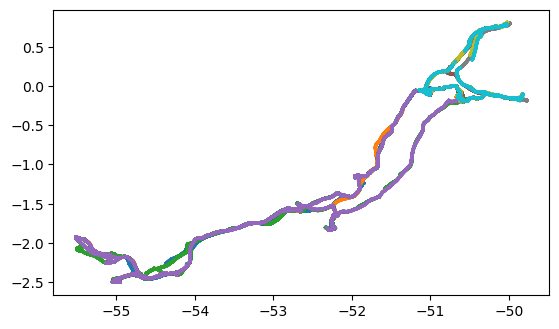

In [9]:
# Still cheating. I'm constructing a GeoDataFrame, not reading one
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs="epsg:4326")
)

gdf.plot(markersize=2, column='TROCAS_nbr');

### GeoParquet demo TO DOs

- Replace pandas `pd.read_parquet` with dask `dd.read_parquet` to leverage lazy loading. Also can leverage Parquet filters (to select based on partitioned columns) and column selection, in `pd.read_parquet`
- Actually use a GeoParquet data store (or ideally find one openly available on object storage)
- Then, use Dask-GeoPandas, https://dask-geopandas.readthedocs.io

## Multi-dimensional grids

- Grid data typically with >2 dimensions: (time,lat,lon), (band,lat,lon), (time,depth,lat,lon), etc
- Examples: Ocean model output. Rainfall gridded time series from remote sensing.
- Labelled arrays, with rich variable, coordinate and dataset metadata.
- Multi-dimensional chunks and compression.
- `netCDF`: the most widely used format in earth sciences. Recent developments allow for some cloud optimization based on internal chunking and HTTP Byte Range access, but that's not its strength.
    - *Tools like `kerchunk` provide Zarr-like "virtual" cloud-optimized datasets out of netcdf collections. Similar to GDAL VRT's*
- `Zarr` (https://zarr.dev): a cloud-optimized format that builds on the `netCDF` data model, conventions and software ecosystem.
    - *Like Parquet, each chunk exists as a separate file object. Metadata stored separately in JSON files.*
- **Python** support: `xarray` (https://docs.xarray.dev), `Zarr` (https://zarr.readthedocs.io), `rioxarray` (https://corteva.github.io/rioxarray/stable/). `xarray` is used extensively. Builds on and extends `Pandas` access patterns

In [10]:
import xarray as xr

# From https://pangeo-forge.org/dashboard/feedstock/78
zarr_store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/AGDC-feedstock/AGCD.zarr'

ds = xr.open_dataset(zarr_store, engine='zarr', chunks={})

# Lazy loading (metadata and coordinate values only)
# Data variables loaded as lazy, chunked "Dask" arrays
print(f"Total size (not downloaded size!): {ds.nbytes/1e9:.1f} GB")
ds

Total size (not downloaded size!): 175.3 GB


<xarray.Dataset>
Dimensions:     (lat: 691, lon: 886, time: 17897)
Coordinates:
  * lat         (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon         (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * time        (time) datetime64[ns] 1971-01-01T09:00:00 ... 2019-12-31T09:0...
Data variables:
    precip      (time, lat, lon) float32 dask.array<chunksize=(40, 691, 886), meta=np.ndarray>
    tmax        (time, lat, lon) float32 dask.array<chunksize=(40, 691, 886), meta=np.ndarray>
    tmin        (time, lat, lon) float32 dask.array<chunksize=(40, 691, 886), meta=np.ndarray>
    vapourpres  (time, lat, lon) float32 dask.array<chunksize=(40, 691, 886), meta=np.ndarray>
Attributes: (12/36)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD (AWAP) v1.0.0 Snapshot (1900-01-01 to 202...
    analysis_components:       0900: the gridded vapour pressure value at 9am...
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The partial pressure of water vapour in air (v...
    time_coverage_end:         1971-12-31T00:00:00
    time_coverage_start:       1971-01-01T15:00:00
    title:                     Interpolated Vapour Pressure
    url:                       http://www.bom.gov.au/climate/
    uuid:                      e684e0a6-73c7-4522-ab78-a8285ca34b4b

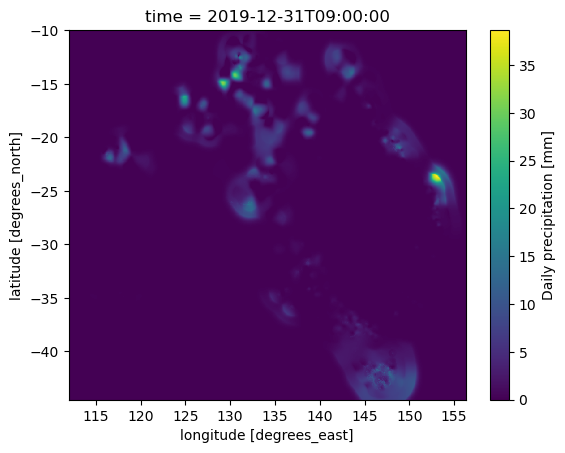

In [11]:
# This is slow; I'm not sure why.
ds['precip'].isel(time=-1).plot();

## Various helpful links

- Cloud-Native Geospatial Foundation, https://cloudnativegeo.org
- https://nasa-openscapes.github.io/earthdata-cloud-cookbook/ (but be aware of frequent cases where registration is required)
- https://cholmes.medium.com/an-overview-of-cloud-native-vector-c223845638e0
- https://mapscaping.com/cloud-native-geospatial-vector-formats/
